# Installs
Requirements above what I currently have in the Docker container

In [1]:
!pip install pydot h5py lmdb
!apt-get install -y graphviz
!pip install jinja2

Downloading/unpacking pydot
  Running setup.py (path:/tmp/pip_build_root/pydot/setup.py) egg_info for package pydot
    Couldn't import dot_parser, loading of dot files will not be possible.
    
Downloading/unpacking lmdb
  Running setup.py (path:/tmp/pip_build_root/lmdb/setup.py) egg_info for package lmdb
    py-lmdb: Using bundled liblmdb; override with LMDB_FORCE_SYSTEM=1.
    py-lmdb: Using CPython extension; override with LMDB_FORCE_CFFI=1.
    
  Running setup.py install for pydot
    Couldn't import dot_parser, loading of dot files will not be possible.
    
  Running setup.py install for lmdb
    py-lmdb: Using bundled liblmdb; override with LMDB_FORCE_SYSTEM=1.
    py-lmdb: Using CPython extension; override with LMDB_FORCE_CFFI=1.
    building 'cpython' extension
    x86_64-linux-gnu-gcc -pthread -fno-strict-aliasing -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -fPIC -Ilib/py-lmdb -Ilib -I/usr/include/python2.7 -c lmdb/cpython.c -o build/temp.linux-x86_64-2.7/lmdb/cpytho

In [1]:
import caffe
import numpy as np
import sys

sys.path.append('..')

from prototxt import write_files
from data import read_data, format_data, split_train_test, write_lmdb
from global_params import DEPLOY_PROTOTXT, IMAGES, LMDB_NAME, PIXELS, TEAMS, SOLVER_PROTOTXT, BATCH_SIZE

# Data

Read the data from raw image files

In [2]:
images, y = read_data(IMAGES, PIXELS, TEAMS)
X = format_data(images)

Split into training and testing data sets

In [3]:
X_train, y_train, X_test, y_test = split_train_test(X, np.array(y))

In [4]:
write_lmdb(LMDB_NAME, X_train, y_train)

# Training

Write necessary caffe files

In [5]:
write_files()

Actually train the network

In [ ]:
caffe.set_mode_cpu()
solver = caffe.get_solver(SOLVER_PROTOTXT)
solver.solve()

# Predictions

In [14]:
caffemodel = 'football_iter_500.caffemodel'

In [15]:
net = caffe.Net(DEPLOY_PROTOTXT, caffemodel, caffe.TEST)

In [19]:
def get_predictions(net, input_data):
    """
    :param net: caffe.Net object
    :param input_data: batch of images in their final format
    :return: index of predicted team
    """
    out = net.forward(data=input_data)
    probabilities = np.squeeze(out[net.outputs[0]])
    return probabilities.argmax(axis=1)

In [27]:
predictions = np.arange(0)
# If the test set isn't a multiple of BATCH_SIZE, the remainder gets left off. Sorry. :)
for start_index in range(0, X_test.shape[0] + 1, BATCH_SIZE)[:-1]:
    preds = get_predictions(net, X_test[start_index:(start_index + BATCH_SIZE)])
    predictions = np.append(predictions, preds)

In [39]:
print "Accuracy: {0:.3f}".format((predictions == y_test[:len(predictions)]).mean())

Accuracy: 0.134


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [29]:
confusion = confusion_matrix(predictions, y_test[:len(predictions)])

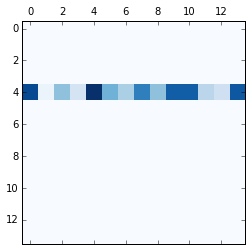

In [30]:
plt.matshow(confusion, cmap=plt.cm.Blues)